Импорт необходимых бибилиотек.

In [ ]:
import matplotlib.pyplot as plt
import cv2 as cv
import skimage
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from skimage.metrics import structural_similarity as ssim
import warnings

1. Загрузка данных в рабочую среду.

In [ ]:
list_clusters = [2, 5, 10, 20]

In [ ]:
# Функция для вывода изображения с названием картинки
def draw_picture(image, title, bgr=False):
  # Разделение многоканального массива на несколько одноканальных, по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
  b, g, r = cv.split(image)
  # Объединение массивов в один многоканальный. Массивы должны быть одинакового размера
  new_image = cv.merge([r, g, b])
  # Вывод картинки
  plt.figure(figsize=(7, 5))
  plt.axis('off')
  plt.imshow(new_image)
  plt.title(title)
  plt.show()

In [ ]:
# Функция для вывода изображения с названием картинки
def draw_picture_small(image, title, bgr=False):
  # Разделение многоканального массива на несколько одноканальных, по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
  b, g, r = cv.split(image)
  # Объединение массивов в один многоканальный. Массивы должны быть одинакового размера
  new_image = cv.merge([r, g, b])
  # Вывод картинки
  plt.rc('font', size = 8)
  plt.figure(figsize=(3, 2))
  plt.axis('off')
  plt.imshow(new_image)
  plt.title(title)
  plt.show()

In [ ]:
# Загрузка изображения
img = cv.imread('111.jpg')

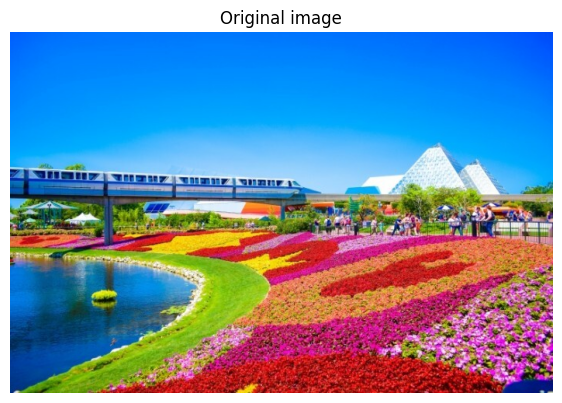

In [ ]:
# Вывод изображения
draw_picture(img, 'Original image', bgr=False)

2. Реализация моделей кластеризации.

2.1. KMeans.

In [ ]:
def KMeans_compression(image, clusters):
  # Необходимо преобразовать 3-х мерный массив данных в 2-х мерный
  w, h, d = image.shape
  image_2d = image.reshape(w*h, d)

  # Инициализируем и обучаем модель KMeans
  model = KMeans(n_clusters = clusters)
  model_KMeans = model.fit(image_2d)

  # Получаем новые цвета - центроиды соответствующего кластера
  new_colors = model_KMeans.cluster_centers_

  # Получаем метку класса для каждого пикселя
  labels = model_KMeans.predict(image_2d)

  # Создаем новое изображение на основе центроидов кластеров
  compr_image = np.zeros((w, h, d), dtype=np.uint8)
  label_idx = 0
  for i in range(w):
    for j in range(h):
      compr_image[i][j] = new_colors[labels[label_idx]]
      label_idx += 1

  # Выводим оригинал изображение и сжатое изображение
  draw_picture(image, 'Original image', bgr=False)
  draw_picture(compr_image, f'Compressed Image for {clusters} clusters', bgr=False)

  # Метрика SSIM для оригинального изоражения
  ssim_none = ssim(img, img, data_range=img.max() - img.min(), channel_axis = 2)
  # Метрика SSIM для сжатого изоражения
  ssim_compressed = ssim(img, compr_image, data_range=compr_image.max() - compr_image.min(), channel_axis = 2)

  print(f'\nМетрика SSIM KMeans оригинальное изображение - {round(ssim_none, 2)}.\nМетрика SSIM KMeans сжатое изображение - {round(ssim_compressed, 2)}, количество кластеров - {clusters}.')

In [ ]:
warnings.filterwarnings("ignore")

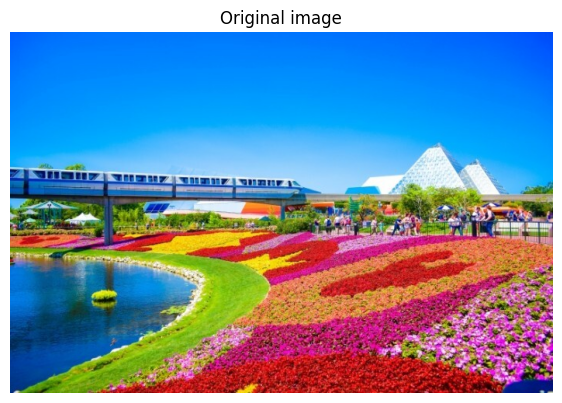

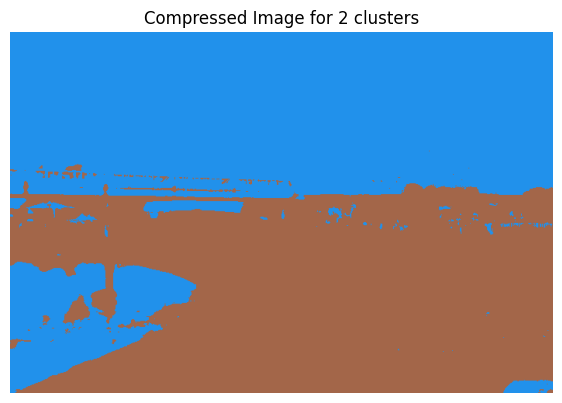


Метрика SSIM KMeans оригинальное изображение - 1.0.
Метрика SSIM KMeans сжатое изображение - 0.34, количество кластеров - 2.


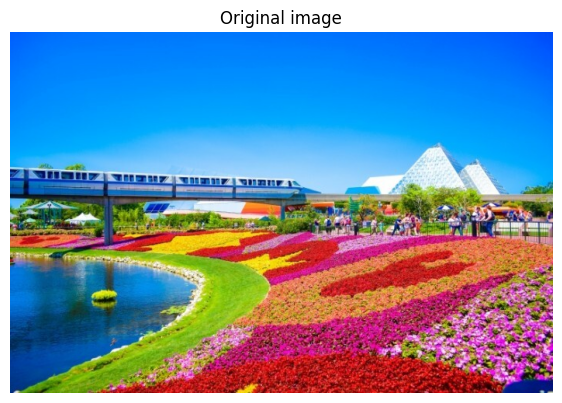

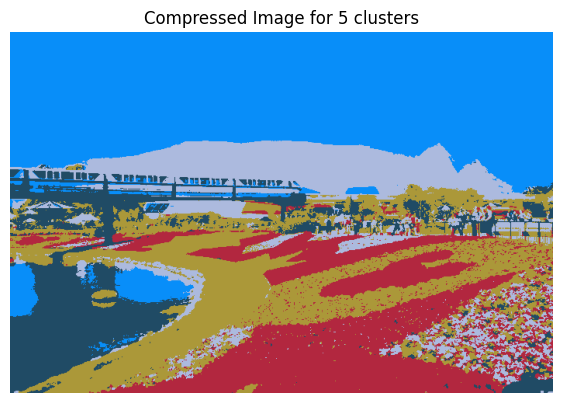


Метрика SSIM KMeans оригинальное изображение - 1.0.
Метрика SSIM KMeans сжатое изображение - 0.5, количество кластеров - 5.


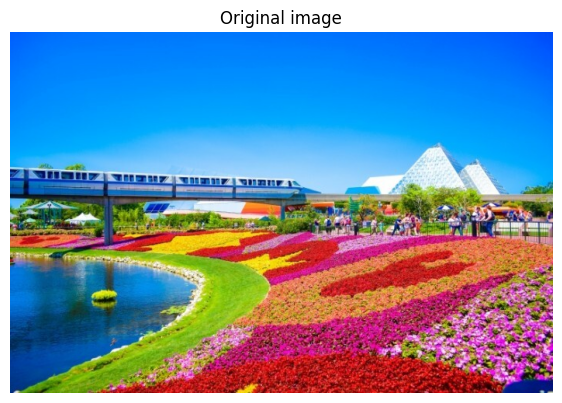

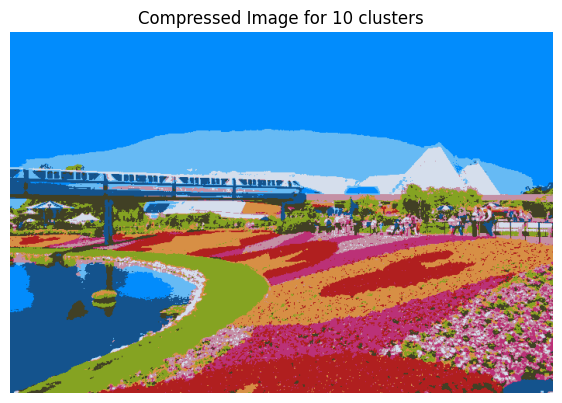


Метрика SSIM KMeans оригинальное изображение - 1.0.
Метрика SSIM KMeans сжатое изображение - 0.68, количество кластеров - 10.


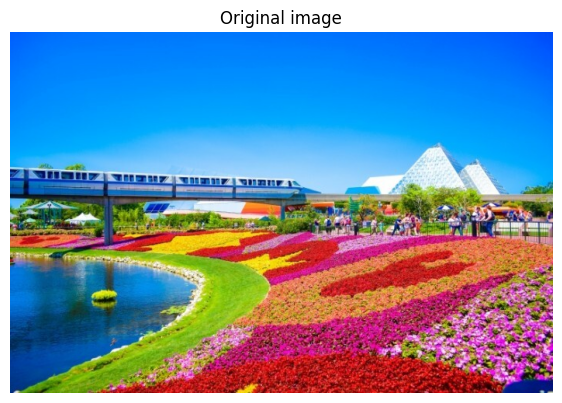

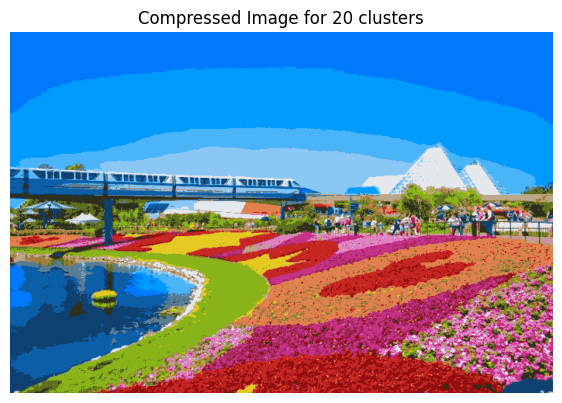


Метрика SSIM KMeans оригинальное изображение - 1.0.
Метрика SSIM KMeans сжатое изображение - 0.78, количество кластеров - 20.
CPU times: user 33.8 s, sys: 7.37 s, total: 41.2 s
Wall time: 25.7 s


In [ ]:
%%time
# Моделирование
for i in list_clusters:
  KMeans_compression(img, i)

2.2. AgglomerativeClustering.

In [ ]:
# Уменьшаю изображение в 4 раза, так как для работы с оригинальным изображением системе не хватает памяти
img_small = cv.resize(img, (175, 116))

In [ ]:
def AgglomerativeClustering_compression(image, clusters):
  # Необходимо преобразовать 3-х мерный массив данных в 2-х мерный
  w, h, d = image.shape
  image_2d = image.reshape(w*h, d)

  # Инициализируем и обучаем модель KMeans
  model = AgglomerativeClustering(n_clusters = clusters)
  model_AC = model.fit(image_2d)

  # Получаем метку класса для каждого пикселя
  labels = model_AC.fit_predict(image_2d)

  # Получаем новые цвета - центроиды кластеров
  new_colors = np.array([np.mean(image_2d[labels == i], axis=0) for i in range(clusters)])

  # Создаем новое изображение на основе центроидов кластеров
  compr_image = np.zeros((w, h, d), dtype=np.uint8)
  label_idx = 0
  for i in range(w):
    for j in range(h):
      compr_image[i][j] = new_colors[labels[label_idx]]
      label_idx += 1

  # Выводим оригинал изображение и сжатое изображение
  draw_picture_small(image, 'Original image', bgr=False)
  draw_picture_small(compr_image, f'Compressed Image for {clusters} clusters', bgr=False)

  # Метрика SSIM для оригинального изоражения
  ssim_none = ssim(image, image, data_range=image.max() - image.min(), channel_axis = 2)
  # Метрика SSIM для сжатого изоражения
  ssim_compressed = ssim(image, compr_image, data_range=compr_image.max() - compr_image.min(), channel_axis = 2)

  print(f'\nМетрика SSIM AgglomerativeClustering оригинальное изображение - {round(ssim_none, 2)}.\nМетрика SSIM AgglomerativeClustering сжатое изображение - {round(ssim_compressed, 2)}, количество кластеров - {clusters}.')

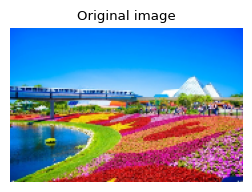

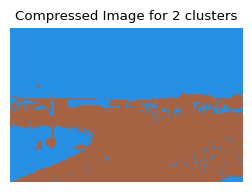


Метрика SSIM AgglomerativeClustering оригинальное изображение - 1.0.
Метрика SSIM AgglomerativeClustering сжатое изображение - 0.29, количество кластеров - 2.


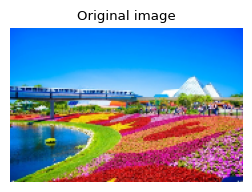

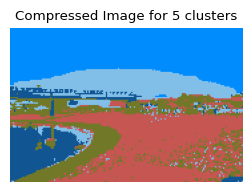


Метрика SSIM AgglomerativeClustering оригинальное изображение - 1.0.
Метрика SSIM AgglomerativeClustering сжатое изображение - 0.56, количество кластеров - 5.


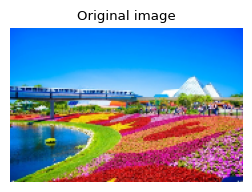

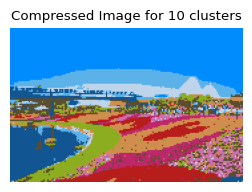


Метрика SSIM AgglomerativeClustering оригинальное изображение - 1.0.
Метрика SSIM AgglomerativeClustering сжатое изображение - 0.73, количество кластеров - 10.


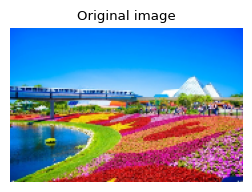

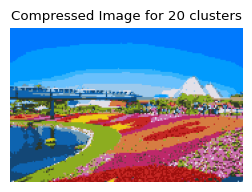


Метрика SSIM AgglomerativeClustering оригинальное изображение - 1.0.
Метрика SSIM AgglomerativeClustering сжатое изображение - 0.8, количество кластеров - 20.
CPU times: user 1min 44s, sys: 12.1 s, total: 1min 56s
Wall time: 1min 56s


In [ ]:
%%time
# Моделирование
for i in list_clusters:
  AgglomerativeClustering_compression(img_small, i)

2.3. DBSCAN.

In [ ]:
def dbscan_compression(image, eps, min_samples):
  # Необходимо преобразовать 3-х мерный массив данных в 2-х мерный
  w, h, d = image.shape
  image_2d = image.reshape(w*h, d)

  # Инициализируем и обучаем модель KMeans
  model = DBSCAN(eps=eps, min_samples=min_samples)
  model_dbscan = model.fit(image_2d)

  # Получаем метку класса для каждого пикселя
  labels = model_dbscan.fit_predict(image_2d)

  # Получаем новые цвета - центроиды кластеров
  unique_labels = np.unique(labels)
  new_colors = np.array([np.mean(image_2d[labels == i], axis=0) for i in unique_labels if i != -1])

  # Создаем новое изображение на основе центроидов кластеров
  compr_image = np.zeros((w, h, d), dtype=np.uint8)
  label_idx = 0
  for i in range(w):
    for j in range(h):
      compr_image[i][j] = new_colors[labels[label_idx]]
      label_idx += 1

  # Выводим оригинал изображение и сжатое изображение
  draw_picture_small(image, 'Original image', bgr=False)
  draw_picture_small(compr_image, f'Compressed Image for eps = {eps}, min_samples = {min_samples}', bgr=False)

  # Метрика SSIM для оригинального изоражения
  ssim_none = ssim(image, image, data_range=image.max() - image.min(), channel_axis = 2)
  # Метрика SSIM для сжатого изоражения
  ssim_compressed = ssim(image, compr_image, data_range=compr_image.max() - compr_image.min(), channel_axis = 2)

  print(f'\nМетрика SSIM DBSCAN оригинальное изображение - {round(ssim_none, 2)}.\nМетрика SSIM DBSCAN сжатое изображение - {round(ssim_compressed, 2)}, eps = {eps}, min_samples = {min_samples}.')

In [ ]:
# Параметры для модели DBSCAN
eps_list = [0.5, 1, 5, 0.5, 1, 5]
min_samples_list = [1, 1, 1, 2, 5, 7]

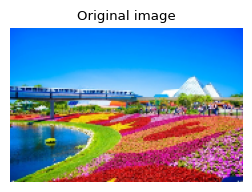

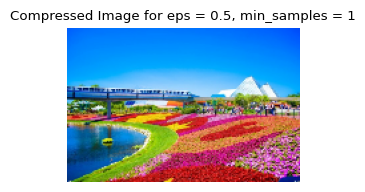


Метрика SSIM DBSCAN оригинальное изображение - 1.0.
Метрика SSIM DBSCAN сжатое изображение - 1.0, eps = 0.5, min_samples = 1.


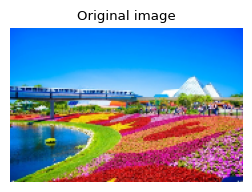

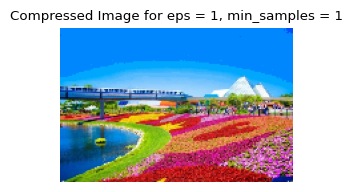


Метрика SSIM DBSCAN оригинальное изображение - 1.0.
Метрика SSIM DBSCAN сжатое изображение - 0.97, eps = 1, min_samples = 1.


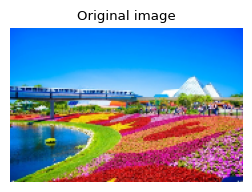

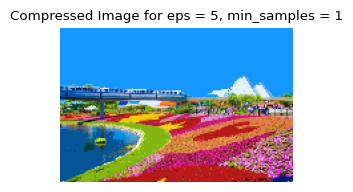


Метрика SSIM DBSCAN оригинальное изображение - 1.0.
Метрика SSIM DBSCAN сжатое изображение - 0.79, eps = 5, min_samples = 1.


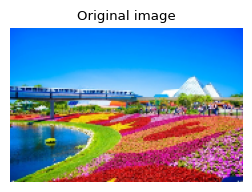

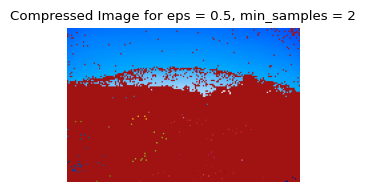


Метрика SSIM DBSCAN оригинальное изображение - 1.0.
Метрика SSIM DBSCAN сжатое изображение - 0.2, eps = 0.5, min_samples = 2.


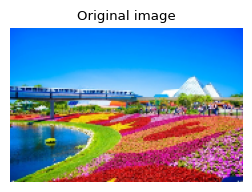

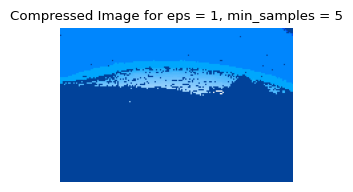


Метрика SSIM DBSCAN оригинальное изображение - 1.0.
Метрика SSIM DBSCAN сжатое изображение - 0.28, eps = 1, min_samples = 5.


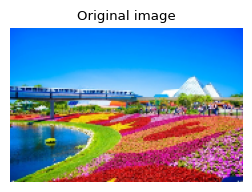

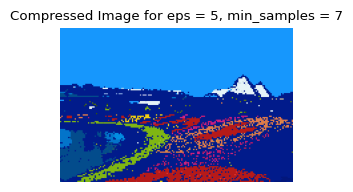


Метрика SSIM DBSCAN оригинальное изображение - 1.0.
Метрика SSIM DBSCAN сжатое изображение - 0.32, eps = 5, min_samples = 7.
CPU times: user 7.89 s, sys: 1.09 s, total: 8.98 s
Wall time: 9.68 s


In [ ]:
%%time
# Моделирование
for j, k in zip(eps_list, min_samples_list):
  dbscan_compression(img_small, j, k)

Выводы:
* если сравнивать между собой модели KMenas и AgglomerativeClustering, то по метрикам немного лучше показался себя модель AgglomerativeClustering при одних и тех же заданных значениях кластеров; но при этом скорость ее работы оказалась намного меньше, чем у KMeans; думаю тут не вполне сопоставимы улучшение метрики и снижение скорости работы, я бы между двух этих моделей выбрал KMeans в данном случае;
* что касается модели DBSCAN, то тут я могу два момента обозначить. Во-первых ее трудно как-то сравнить с KMenas и AgglomerativeClustering, посколько кол-во кластеров не задано и варьируя параметры eps и min_samples мы можем получать различное значение метрики и различную потерю цветов в цветовой палитре. В реальных задачах наверное нужно искать баланс между требуемым размером сжатого изображения и его качеством и подбирая параметры eps и min_samples получать изображения, удовлятворяющие требуемуму соотношению размер/качество. Во-вторых возникла трудность в интерпретации результата DBSCAN: при значении параметра min_samples = 1 и плавно увеличивая параметр eps я получаю плавное снижении метрики SSIM и соответственно плавное снижение количества цветов в палитре. Но стоит только увеличить min_samples до значения 2 и выше метрика резко падает вниз, как и палитра цветов на сжатом изображении, то есть количество кластеров по итогу получается равное 2 или 3. И я не до конца понимаю, о чем это говорит. И как не меняй там параметр eps метрика остается низкая.